# 🎯 Evaluación RAGAS para Sistema RAG de Matrículas UNSA

Este notebook evalúa el rendimiento de tu sistema RAG usando el framework RAGAS.

**Métricas evaluadas:**
- **Faithfulness**: ¿La respuesta está basada en el contexto recuperado?
- **Answer Relevancy**: ¿La respuesta es relevante a la pregunta?
- **Context Precision**: ¿Los contextos recuperados son precisos?
- **Context Recall**: ¿Se recuperaron todos los contextos necesarios?
- **Context Relevancy**: ¿Los contextos son relevantes a la pregunta?

## 📌 Instrucciones:
1. Ejecuta el notebook en Google Colab (GPU recomendada)
2. Sube tu archivo `ragas_evaluation_dataset.json`
3. Ejecuta todas las celdas
4. Descarga los resultados

## 1️⃣ Instalación de Dependencias

In [ ]:
%%capture
# 1. Instalar el core compatible con Ragas (v0.2.x)
!pip install "langchain-core<0.3.0"

# 2. FORZAR la actualización del SDK de Google (esto soluciona el error de MediaResolution)
!pip install --upgrade google-generativeai

# 3. Instalar el resto de dependencias
!pip install --upgrade langchain-google-genai langchain ragas langchain-community
!pip install pandas matplotlib seaborn plotly

## 2️⃣ Configuración de API Key de Google Gemini

RAGAS usa LLMs para evaluar. Usaremos **Google Gemini API Tier 1**:
- **1,000 requests/minuto** + **1M tokens/minuto** + **10K requests/día**
- Modelo: Gemini 2.5 Flash (temperature=0.0 para consistencia)
- ⏱️ Tiempo estimado: **1-2 minutos** para 50 evaluaciones (batch_size=10)
- 🎲 Seed fijo (42) para resultados reproducibles

In [ ]:
import os
from google.colab import userdata

# Configurar Google Gemini API Key
# Obtén tu API key GRATIS en: https://aistudio.google.com/app/apikey
try:
    gemini_key = userdata.get('GOOGLE_API_KEY')
    os.environ['GOOGLE_API_KEY'] = gemini_key
    print("✅ Google Gemini configurado exitosamente")
    print(f"   API Key: {gemini_key[:10]}...{gemini_key[-4:]}")
    print(f"   Límites: 1,500 requests/día + 1M tokens/mes")
    print(f"   ⏱️ Tiempo estimado: 5-10 minutos\n")
except Exception as e:
    print("❌ No se encontró GOOGLE_API_KEY")
    print("\n🎯 Pasos para configurar (2 minutos):")
    print("   1. Ve a: https://aistudio.google.com/app/apikey")
    print("   2. Inicia sesión con tu cuenta Google")
    print("   3. Click en 'Create API Key'")
    print("   4. Copia tu API key (empieza con AIza...)")
    print("   5. En Colab: Click en 🔑 (Secrets, barra lateral)")
    print("   6. Agrega nuevo secreto:")
    print("      • Name: GOOGLE_API_KEY")
    print("      • Value: tu_api_key")
    print("   7. Activa el toggle para habilitar")
    print("   8. Re-ejecuta esta celda")
    raise

✅ Google Gemini configurado exitosamente
   API Key: AIzaSyAlXN...I6FA
   Límites: 1,500 requests/día + 1M tokens/mes
   ⏱️ Tiempo estimado: 5-10 minutos



## 3️⃣ Cargar Dataset de Evaluación

In [ ]:
import json
import pandas as pd
from google.colab import files

# Subir archivo
print("📁 Por favor, sube el archivo 'ragas_evaluation_dataset.json'")
uploaded = files.upload()

# Cargar datos
filename = list(uploaded.keys())[0]
with open(filename, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

print(f"\n✅ Dataset cargado: {len(dataset)} casos de prueba")
print(f"\n📊 Vista previa:")
df_preview = pd.DataFrame([
    {
        'question': item['question'][:60] + '...',
        'answer_length': len(item['answer']),
        'num_contexts': len(item['contexts']),
        'has_ground_truth': item.get('ground_truth') is not None
    }
    for item in dataset[:5]
])
print(df_preview.to_string(index=False))

📁 Por favor, sube el archivo 'ragas_evaluation_dataset.json'


Saving ragas_evaluation_dataset (3).json to ragas_evaluation_dataset (3).json

✅ Dataset cargado: 50 casos de prueba

📊 Vista previa:
                                                       question  answer_length  num_contexts  has_ground_truth
¿Cuál es el rango de fechas exacto para la presentación de e...             38             5              True
¿Cuándo es la fecha de inicio de clases para el año académic...             78             5              True
¿En qué fechas se debe enviar el correo para el Levantamient...            139             5              True
¿Cuál es el plazo establecido para realizar el trámite de Re...            133             5              True
¿Cuál es el periodo para la expedición, registro de Resoluci...            150             5              True


## 4️⃣ Preparar Datos para RAGAS

In [ ]:
from datasets import Dataset

# Convertir a formato RAGAS
ragas_data = {
    'question': [],
    'answer': [],
    'contexts': [],
    'ground_truth': []
}

for item in dataset:
    ragas_data['question'].append(item['question'])
    ragas_data['answer'].append(item['answer'])
    ragas_data['contexts'].append(item['contexts'])

    # Si no hay ground_truth, usar la respuesta como fallback
    gt = item.get('ground_truth')
    ragas_data['ground_truth'].append(gt if gt else item['answer'])

# Crear dataset de HuggingFace
evaluation_dataset = Dataset.from_dict(ragas_data)
print(f"✅ Dataset preparado para evaluación: {len(evaluation_dataset)} muestras")

✅ Dataset preparado para evaluación: 50 muestras


## 5️⃣ Configurar Métricas RAGAS

In [ ]:
# Verificar versión de RAGAS y métricas disponibles
import ragas
from ragas import metrics

print("="*80)
print("📦 INFORMACIÓN DE RAGAS")
print("="*80)
print(f"\n🔢 Versión de RAGAS: {ragas.__version__}")
print("\n📊 Métricas disponibles en esta versión:")
print("-" * 80)

# Listar todas las métricas disponibles
available_metrics = [attr for attr in dir(metrics) if not attr.startswith('_')]
for i, metric in enumerate(available_metrics, 1):
    print(f"  {i:2d}. {metric}")

print("\n" + "="*80)
print("📚 Documentación oficial: https://docs.ragas.io/en/latest/")
print("="*80)

📦 INFORMACIÓN DE RAGAS

🔢 Versión de RAGAS: 0.4.1

📊 Métricas disponibles en esta versión:
--------------------------------------------------------------------------------
   1. AgentGoalAccuracyWithReference
   2. AgentGoalAccuracyWithoutReference
   3. AnswerAccuracy
   4. AnswerCorrectness
   5. AnswerRelevancy
   6. AnswerSimilarity
   7. AspectCritic
   8. BaseMetric
   9. BleuScore
  10. ChrfScore
  11. ContextEntityRecall
  12. ContextPrecision
  13. ContextRecall
  14. ContextRelevance
  15. ContextUtilization
  16. DataCompyScore
  17. DiscreteMetric
  18. DistanceMeasure
  19. ExactMatch
  20. FactualCorrectness
  21. Faithfulness
  22. FaithfulnesswithHHEM
  23. IDBasedContextPrecision
  24. IDBasedContextRecall
  25. InstanceRubrics
  26. LLMContextPrecisionWithReference
  27. LLMContextPrecisionWithoutReference
  28. LLMContextRecall
  29. LLMMetric
  30. LLMSQLEquivalence
  31. Metric
  32. MetricOutputType
  33. MetricResult
  34. MetricType
  35. MetricWithEmbeddings
  

In [ ]:
# Importar métricas de RAGAS 0.4.x
from ragas.metrics import (
    ContextPrecision,   # Métrica #12 - Para RQ3 (Calidad de Búsqueda)
    ContextRecall,      # Métrica #13 - Para RQ3 (¿Encontró el documento?)
    Faithfulness,       # Métrica #21 - Para RQ2 (Anti-Alucinación)
    AnswerRelevancy,    # Métrica #5  - Calidad de Respuesta
    AnswerCorrectness   # Métrica #4  - Para RQ3 (Exactitud vs Ground Truth)
)

print("✅ Métricas importadas correctamente")

# Verificar disponibilidad de ground_truth
has_ground_truth = any(gt and gt != ans for gt, ans in zip(ragas_data['ground_truth'], ragas_data['answer']))

if has_ground_truth:
    print("✅ Detectado ground_truth - Evaluando TODAS las métricas (incluyendo AnswerCorrectness)")
    metrics = [
        ContextPrecision(),      # RQ3: ¿Los contextos recuperados son precisos?
        ContextRecall(),         # RQ3: ¿Se recuperaron todos los contextos relevantes?
        Faithfulness(),          # RQ2: ¿La respuesta se basa en el contexto?
        AnswerRelevancy(),       # Calidad: ¿La respuesta es relevante a la pregunta?
        AnswerCorrectness()      # RQ3: ¿La respuesta coincide con el ground_truth?
    ]
else:
    print("⚠️ Sin ground_truth - Evaluando métricas básicas (sin AnswerCorrectness)")
    metrics = [
        ContextPrecision(),
        ContextRecall(),
        Faithfulness(),
        AnswerRelevancy()
    ]

print(f"\n📊 Métricas configuradas: {len(metrics)} métricas")
for i, metric in enumerate(metrics, 1):
    print(f"  {i}. {metric.__class__.__name__}")

✅ Métricas importadas correctamente
✅ Detectado ground_truth - Evaluando TODAS las métricas (incluyendo AnswerCorrectness)

📊 Métricas configuradas: 5 métricas
  1. ContextPrecision
  2. ContextRecall
  3. Faithfulness
  4. AnswerRelevancy
  5. AnswerCorrectness


## 6️⃣ Ejecutar Evaluación RAGAS

⏱️ **Esto puede tomar varios minutos** dependiendo del tamaño del dataset

In [ ]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.run_config import RunConfig
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness, AnswerRelevancy, AnswerCorrectness
import pandas as pd
import time
import os

print("🚀 Iniciando evaluación RAGAS con Gemini API Tier 1...")
print("   ⚡ Modo rápido habilitado (1,000 RPM disponibles)\n")

try:
    if 'GOOGLE_API_KEY' not in os.environ:
        raise ValueError("❌ Falta GOOGLE_API_KEY")

    # 1. Configuración del Modelo (Gemini 2.5 Flash - Optimizado)
    gemini_llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        temperature=0.0,           # 0.0 para máxima consistencia (vs 0.1)
        max_retries=3,             # Reintentos automáticos
        request_timeout=60,        # Timeout de 60s por request
        google_api_key=os.environ['GOOGLE_API_KEY']
    )
    llm = LangchainLLMWrapper(gemini_llm)

    # 2. Configuración de Embeddings
    lc_embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )
    ragas_embeddings = LangchainEmbeddingsWrapper(lc_embeddings)

    # 3. Configuración de RunConfig para Reproducibilidad
    run_config = RunConfig(
        timeout=180,               # 3 minutos máximo por operación
        max_retries=3,             # 3 reintentos (vs 10 default) - suficiente con Tier 1
        max_wait=30,               # 30s máximo entre reintentos (vs 60s)
        max_workers=16,            # 16 workers concurrentes (default) - aprovecha Tier 1
        seed=42,                   # Seed fijo para reproducibilidad
        log_tenacity=True          # Activar logs de reintentos para debugging
    )

    print(f"⚙️ RunConfig: seed={run_config.seed}, max_workers={run_config.max_workers}")

    # 4. Creación de Métricas (RAGAS 0.4.x)
    has_gt = any(gt and gt != ans for gt, ans in zip(ragas_data['ground_truth'], ragas_data['answer']))

    if has_gt:
        print("✅ Ground Truth detectado - Evaluando con AnswerCorrectness")
        metrics_list = [
            ContextPrecision(),
            ContextRecall(),
            Faithfulness(),
            AnswerRelevancy(),
            AnswerCorrectness()
        ]
    else:
        print("⚠️ Sin Ground Truth - Evaluando métricas básicas")
        metrics_list = [
            ContextPrecision(),
            ContextRecall(),
            Faithfulness(),
            AnswerRelevancy()
        ]

    # Asignamos LLM y Embeddings
    for m in metrics_list:
        m.llm = llm
        m.embeddings = ragas_embeddings

    # 5. Procesamiento Optimizado para Gemini API Tier 1
    batch_size = 10  # Procesar 10 muestras en paralelo (optimizado para Tier 1)

    all_results = []
    total_samples = len(evaluation_dataset)

    print(f"📊 Dataset: {total_samples} muestras")
    print(f"⚡ Procesando en lotes de {batch_size} (Gemini Tier 1: 1,000 RPM)")
    print(f"🎲 Seed reproducible: {run_config.seed} | Workers: {run_config.max_workers}")

    start_global = time.time()

    for i in range(0, total_samples, batch_size):
        # Seleccionar lote de muestras
        end_idx = min(i + batch_size, total_samples)
        batch_data = evaluation_dataset.select(range(i, end_idx))
        batch_num = (i // batch_size) + 1
        total_batches = (total_samples + batch_size - 1) // batch_size

        print(f"\n🔄 Lote {batch_num}/{total_batches}: Evaluando preguntas {i+1}-{end_idx}...")

        try:
            # Evaluar lote completo con RunConfig
            batch_result = evaluate(
                dataset=batch_data,
                metrics=metrics_list,
                llm=llm,
                embeddings=ragas_embeddings,
                run_config=run_config,     # ⭐ RunConfig para reproducibilidad
                raise_exceptions=False
            )
            all_results.append(batch_result.to_pandas())

            elapsed_batch = time.time() - start_global
            avg_time_per_sample = elapsed_batch / end_idx
            eta_seconds = avg_time_per_sample * (total_samples - end_idx)

            print(f"   ✅ Completado en {elapsed_batch:.1f}s")
            print(f"   ⏱️ Tiempo estimado restante: {eta_seconds/60:.1f} min")

        except Exception as e:
            print(f"   ❌ Error en este lote: {str(e)}")

    # 6. Guardar Resultados
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)

        class ResultWrapper:
            def to_pandas(self):
                return final_df

        results = ResultWrapper()

        elapsed = time.time() - start_global
        print(f"\n🎉 ¡ÉXITO TOTAL! Tiempo: {elapsed/60:.1f} min.")
    else:
        print("\n❌ No se pudo evaluar nada. Revisa tu API Key.")

except Exception as e:
    import traceback
    print(f"\n❌ Error Fatal: {str(e)}")
    traceback.print_exc()

🚀 Iniciando evaluación RAGAS con Gemini API Tier 1...
   ⚡ Modo rápido habilitado (1,000 RPM disponibles)



/tmp/ipython-input-730440437.py:27: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  llm = LangchainLLMWrapper(gemini_llm)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/tmp/ipython-input-730440437.py:33: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  ragas_embeddings = LangchainEmbeddingsWrapper(lc_embeddings)


⚙️ RunConfig: seed=42, max_workers=16
✅ Ground Truth detectado - Evaluando con AnswerCorrectness
📊 Dataset: 50 muestras
⚡ Procesando en lotes de 10 (Gemini Tier 1: 1,000 RPM)
🎲 Seed reproducible: 42 | Workers: 16

🔄 Lote 1/5: Evaluando preguntas 1-10...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Completado en 204.7s
   ⏱️ Tiempo estimado restante: 13.6 min

🔄 Lote 2/5: Evaluando preguntas 11-20...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Completado en 405.5s
   ⏱️ Tiempo estimado restante: 10.1 min

🔄 Lote 3/5: Evaluando preguntas 21-30...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Completado en 603.2s
   ⏱️ Tiempo estimado restante: 6.7 min

🔄 Lote 4/5: Evaluando preguntas 31-40...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Completado en 811.3s
   ⏱️ Tiempo estimado restante: 3.4 min

🔄 Lote 5/5: Evaluando preguntas 41-50...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Completado en 1015.1s
   ⏱️ Tiempo estimado restante: 0.0 min

🎉 ¡ÉXITO TOTAL! Tiempo: 16.9 min.


In [ ]:
import pandas as pd

# 1. Aseguramos que tenemos el DataFrame base
if 'all_results' in locals() and len(all_results) > 0:
    results_df = pd.concat(all_results, ignore_index=True)

    print(f"📊 Recuperadas {len(results_df)} filas de métricas.")
    print(f"   Columnas detectadas: {list(results_df.columns)}")

    # 2. REPARACIÓN: Pegamos las columnas de texto originales (pregunta, respuesta, contexto)
    # Tomamos tantas preguntas del original como resultados hayamos logrado procesar
    count = len(results_df)

    # Extraemos los datos originales alineados
    original_subset = evaluation_dataset.select(range(count))

    # Los insertamos en el dataframe de resultados si faltan
    if 'question' not in results_df.columns:
        results_df['question'] = original_subset['question']
        print("   ✅ Columna 'question' restaurada.")

    if 'answer' not in results_df.columns:
        results_df['answer'] = original_subset['answer']
        print("   ✅ Columna 'answer' restaurada.")

    if 'contexts' not in results_df.columns:
        results_df['contexts'] = original_subset['contexts']
        print("   ✅ Columna 'contexts' restaurada.")

    if 'ground_truth' not in results_df.columns and 'ground_truth' in original_subset.features:
         results_df['ground_truth'] = original_subset['ground_truth']
         print("   ✅ Columna 'ground_truth' restaurada.")

    # 3. Preparamos el objeto final para las siguientes celdas
    class ResultWrapper:
        def to_pandas(self):
            return results_df

    results = ResultWrapper()

    print("\n✨ ¡Tabla reparada! Vista previa:")
    print(results_df[['question', 'faithfulness', 'answer_relevancy']].head(3))

    print(f"\n🚀 TODO LISTO. Ahora ve a la Celda 12 ('Resultados Generales') y ejecútala.")

else:
    print("❌ No hay resultados en memoria ('all_results' está vacío).")

📊 Recuperadas 50 filas de métricas.
   Columnas detectadas: ['user_input', 'retrieved_contexts', 'response', 'reference', 'context_precision', 'context_recall', 'faithfulness', 'answer_relevancy', 'answer_correctness']
   ✅ Columna 'question' restaurada.
   ✅ Columna 'answer' restaurada.
   ✅ Columna 'contexts' restaurada.
   ✅ Columna 'ground_truth' restaurada.

✨ ¡Tabla reparada! Vista previa:
                                            question  faithfulness  \
0  ¿Cuál es el rango de fechas exacto para la pre...           0.0   
1  ¿Cuándo es la fecha de inicio de clases para e...           1.0   
2  ¿En qué fechas se debe enviar el correo para e...           0.0   

   answer_relevancy  
0          0.306001  
1          0.994486  
2          0.532741  

🚀 TODO LISTO. Ahora ve a la Celda 12 ('Resultados Generales') y ejecútala.


## 7️⃣ Resultados Generales

In [ ]:
import pandas as pd
import numpy as np

# Convertir resultados a DataFrame (si hace falta)
# results_df = results.to_pandas() # Asumimos que results_df ya existe de la celda anterior

print("="*80)
print("📊 RESULTADOS DE EVALUACIÓN RAGAS")
print("="*80)

# CORRECCIÓN: Usamos select_dtypes para tomar SOLO columnas numéricas
# Esto evita que intente promediar textos como 'user_input' o 'response'
numeric_df = results_df.select_dtypes(include=[np.number])
metric_columns = numeric_df.columns.tolist()

print("\n📈 Métricas Promedio:")
print("-" * 50)

if not metric_columns:
    print("⚠️ No se encontraron columnas numéricas para evaluar.")
    print("   Columnas disponibles:", results_df.columns.tolist())
else:
    for metric in metric_columns:
        score = results_df[metric].mean()
        emoji = "🟢" if score > 0.7 else "🟡" if score > 0.5 else "🔴"
        print(f"{emoji} {metric:25s}: {score:.4f}")

print("\n" + "="*80)
print("\n📊 Interpretación de Métricas:")
print("-" * 50)
print("🟢 > 0.7  : Excelente")
print("🟡 0.5-0.7: Bueno (necesita mejoras)")
print("🔴 < 0.5  : Requiere atención urgente")
print("="*80)

📊 RESULTADOS DE EVALUACIÓN RAGAS

📈 Métricas Promedio:
--------------------------------------------------
🔴 context_precision        : 0.4397
🟢 context_recall           : 0.7500
🟢 faithfulness             : 0.8458
🟢 answer_relevancy         : 0.7367
🟡 answer_correctness       : 0.6313


📊 Interpretación de Métricas:
--------------------------------------------------
🟢 > 0.7  : Excelente
🟡 0.5-0.7: Bueno (necesita mejoras)
🔴 < 0.5  : Requiere atención urgente


## 8️⃣ Análisis Detallado por Pregunta

In [ ]:
# Top 5 mejores respuestas
print("\n🏆 TOP 5 MEJORES RESPUESTAS:")
print("="*80)

if 'faithfulness' in results_df.columns:
    top_5 = results_df.nlargest(5, 'faithfulness')[['question', 'faithfulness', 'answer_relevancy']]
    for idx, row in top_5.iterrows():
        print(f"\n📌 Pregunta: {row['question'][:70]}...")
        print(f"   Faithfulness: {row['faithfulness']:.3f} | Answer Relevancy: {row['answer_relevancy']:.3f}")

# Bottom 5 respuestas que necesitan mejora
print("\n\n⚠️ TOP 5 RESPUESTAS QUE NECESITAN MEJORA:")
print("="*80)

if 'faithfulness' in results_df.columns:
    bottom_5 = results_df.nsmallest(5, 'faithfulness')[['question', 'faithfulness', 'answer_relevancy']]
    for idx, row in bottom_5.iterrows():
        print(f"\n📌 Pregunta: {row['question'][:70]}...")
        print(f"   Faithfulness: {row['faithfulness']:.3f} | Answer Relevancy: {row['answer_relevancy']:.3f}")


🏆 TOP 5 MEJORES RESPUESTAS:

📌 Pregunta: ¿Cuándo es la fecha de inicio de clases para el año académico 2025?...
   Faithfulness: 1.000 | Answer Relevancy: 0.994

📌 Pregunta: ¿Cuál es el plazo establecido para realizar el trámite de Reactualizac...
   Faithfulness: 1.000 | Answer Relevancy: 1.000

📌 Pregunta: ¿En qué fechas se realiza la modificación de matrículas y matrículas p...
   Faithfulness: 1.000 | Answer Relevancy: 0.976

📌 Pregunta: ¿Cuál es la duración mínima de un periodo anual bajo el régimen de est...
   Faithfulness: 1.000 | Answer Relevancy: 1.000

📌 Pregunta: ¿Por cuánto tiempo máximo consecutivo o alterno puede un estudiante so...
   Faithfulness: 1.000 | Answer Relevancy: 0.950


⚠️ TOP 5 RESPUESTAS QUE NECESITAN MEJORA:

📌 Pregunta: ¿Cuál es el rango de fechas exacto para la presentación de expedientes...
   Faithfulness: 0.000 | Answer Relevancy: 0.306

📌 Pregunta: ¿En qué fechas se debe enviar el correo para el Levantamiento de Reser...
   Faithfulness: 0.000 | An

In [ ]:
# Buscar la fila del problema del cronograma
problem_row = results_df[results_df['question'].str.contains("cronograma", case=False, na=False)]

if not problem_row.empty:
    row = problem_row.iloc[0]
    print("🕵️ AUTOPSIA DEL ERROR (Cronograma):")
    print("="*60)
    print(f"❓ Pregunta: {row['question']}")
    print("-" * 60)
    print(f"🤖 Respuesta del Chatbot:\n{row['answer']}")
    print("-" * 60)
    print(f"📚 Contexto que leyó (lo que realmente dicen los docs):\n{row['contexts']}")
    print("="*60)
    print("💡 Si la respuesta tiene fechas que NO están en el contexto, ¡es una alucinación!")
else:
    print("No se encontró la pregunta del cronograma.")

No se encontró la pregunta del cronograma.


## 9️⃣ Visualizaciones

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-233771368.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('ragas_evaluation_dashboard.png', dpi=300, bbox_inches='tight')



💾 Dashboard guardado como 'ragas_evaluation_dashboard.png'


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


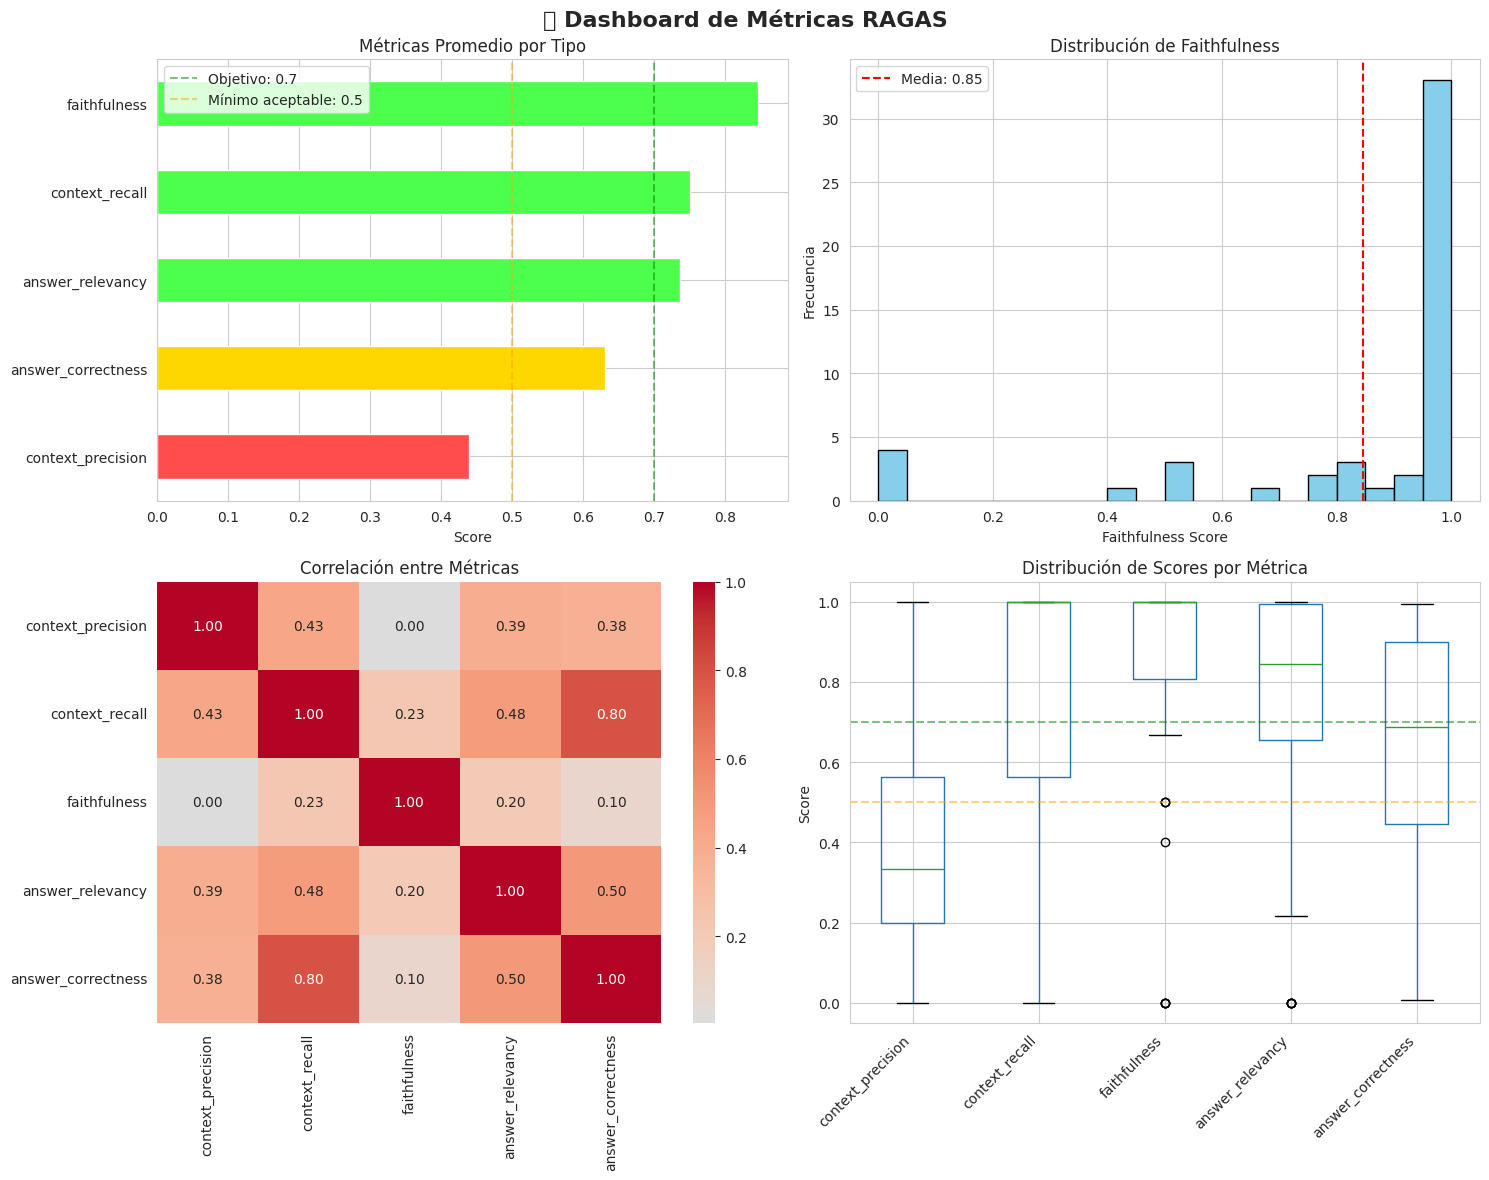

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Dashboard de Métricas RAGAS', fontsize=16, fontweight='bold')

# 1. Distribución de métricas
ax1 = axes[0, 0]
metric_means = results_df[metric_columns].mean().sort_values()
colors = ['#ff4d4d' if x < 0.5 else '#ffd700' if x < 0.7 else '#4dff4d' for x in metric_means]
metric_means.plot(kind='barh', ax=ax1, color=colors)
ax1.set_title('Métricas Promedio por Tipo')
ax1.set_xlabel('Score')
ax1.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Objetivo: 0.7')
ax1.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Mínimo aceptable: 0.5')
ax1.legend()

# 2. Distribución de Faithfulness
if 'faithfulness' in results_df.columns:
    ax2 = axes[0, 1]
    results_df['faithfulness'].hist(bins=20, ax=ax2, color='skyblue', edgecolor='black')
    ax2.set_title('Distribución de Faithfulness')
    ax2.set_xlabel('Faithfulness Score')
    ax2.set_ylabel('Frecuencia')
    ax2.axvline(x=results_df['faithfulness'].mean(), color='red', linestyle='--', label=f'Media: {results_df["faithfulness"].mean():.2f}')
    ax2.legend()

# 3. Correlación entre métricas
ax3 = axes[1, 0]
corr_matrix = results_df[metric_columns].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=ax3, center=0)
ax3.set_title('Correlación entre Métricas')

# 4. Box plot de todas las métricas
ax4 = axes[1, 1]
results_df[metric_columns].boxplot(ax=ax4)
ax4.set_title('Distribución de Scores por Métrica')
ax4.set_ylabel('Score')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.axhline(y=0.7, color='green', linestyle='--', alpha=0.5)
ax4.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('ragas_evaluation_dashboard.png', dpi=300, bbox_inches='tight')
print("\n💾 Dashboard guardado como 'ragas_evaluation_dashboard.png'")
plt.show()

## 🔟 Análisis de Contextos

💾 Análisis de contextos guardado como 'context_analysis.png'


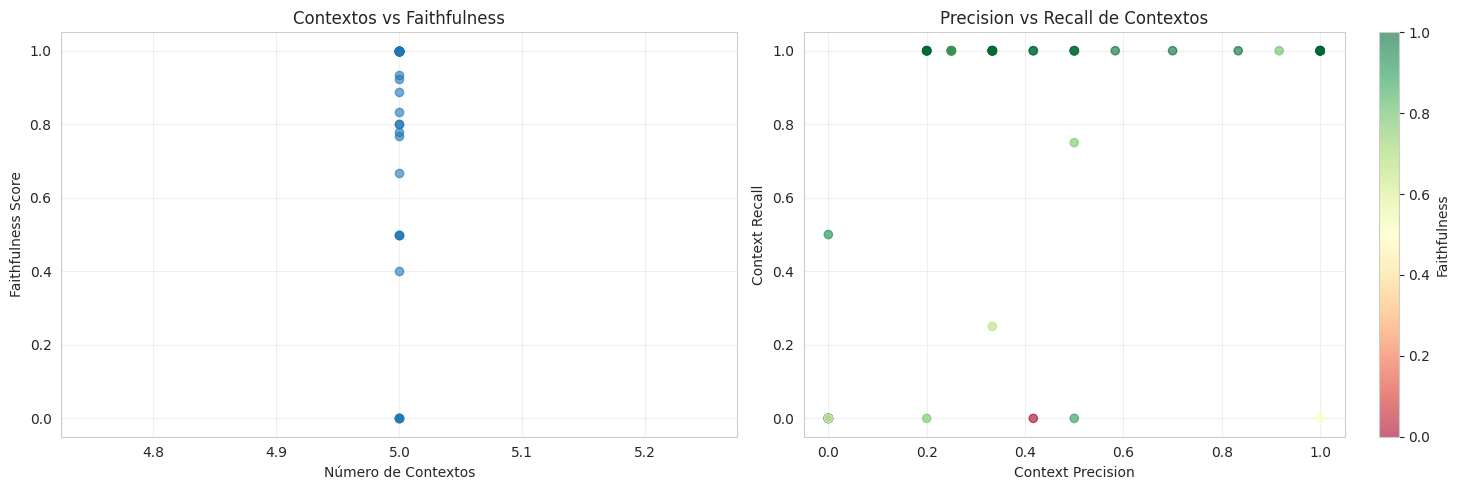


📊 Estadísticas de Contextos:
   Promedio de contextos: 5.00
   Mínimo: 5
   Máximo: 5


In [ ]:
# Analizar relación entre número de contextos y calidad de respuestas
results_df['num_contexts'] = results_df['contexts'].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Número de contextos vs Faithfulness
if 'faithfulness' in results_df.columns:
    axes[0].scatter(results_df['num_contexts'], results_df['faithfulness'], alpha=0.6)
    axes[0].set_xlabel('Número de Contextos')
    axes[0].set_ylabel('Faithfulness Score')
    axes[0].set_title('Contextos vs Faithfulness')
    axes[0].grid(True, alpha=0.3)

# Context precision vs recall (si están disponibles)
if 'context_precision' in results_df.columns and 'context_recall' in results_df.columns:
    axes[1].scatter(results_df['context_precision'], results_df['context_recall'], alpha=0.6, c=results_df['faithfulness'], cmap='RdYlGn')
    axes[1].set_xlabel('Context Precision')
    axes[1].set_ylabel('Context Recall')
    axes[1].set_title('Precision vs Recall de Contextos')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(axes[1].collections[0], ax=axes[1], label='Faithfulness')

plt.tight_layout()
plt.savefig('context_analysis.png', dpi=300, bbox_inches='tight')
print("💾 Análisis de contextos guardado como 'context_analysis.png'")
plt.show()

# Estadísticas de contextos
print("\n📊 Estadísticas de Contextos:")
print(f"   Promedio de contextos: {results_df['num_contexts'].mean():.2f}")
print(f"   Mínimo: {results_df['num_contexts'].min()}")
print(f"   Máximo: {results_df['num_contexts'].max()}")

## 1️⃣1️⃣ Exportar Resultados Completos

In [ ]:
from datetime import datetime
import numpy as np
import json
from google.colab import files

# Crear timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Guardar resultados detallados en CSV
csv_filename = f'ragas_results_detailed_{timestamp}.csv'
results_df.to_csv(csv_filename, index=False, encoding='utf-8')
print(f"✅ Resultados detallados guardados: {csv_filename}")

# Guardar resumen en JSON (CORREGIDO)
summary = {
    'timestamp': timestamp,
    'num_samples': len(results_df),
    'metrics': {
        metric: {
            # Convertimos tipos numpy a python nativo (float)
            'mean': float(results_df[metric].mean()),
            'std': float(results_df[metric].std()) if not pd.isna(results_df[metric].std()) else 0.0,
            'min': float(results_df[metric].min()),
            'max': float(results_df[metric].max())
        }
        for metric in metric_columns
    },
    'interpretation': {
        # CORRECCIÓN AQUÍ: Usamos int() para convertir el numpy.int64 a int normal
        'excellent': int(sum((results_df[metric_columns].mean() > 0.7).values)),
        'good': int(sum(((results_df[metric_columns].mean() >= 0.5) & (results_df[metric_columns].mean() <= 0.7)).values)),
        'needs_improvement': int(sum((results_df[metric_columns].mean() < 0.5).values))
    }
}

json_filename = f'ragas_summary_{timestamp}.json'
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print(f"✅ Resumen guardado: {json_filename}")

# Descargar archivos
print("\n📥 Descargando archivos...")
try:
    files.download(csv_filename)
    files.download(json_filename)
    files.download('ragas_evaluation_dashboard.png')
    files.download('context_analysis.png')
    print("\n✅ ¡Evaluación completada exitosamente!")
except Exception as e:
    print(f"⚠️ Los archivos se guardaron en Colab pero falló la descarga automática: {e}")
    print("   Puedes descargarlos manualmente desde el panel de archivos a la izquierda (icono carpeta).")

✅ Resultados detallados guardados: ragas_results_detailed_20251213_060034.csv
✅ Resumen guardado: ragas_summary_20251213_060034.json

📥 Descargando archivos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ ¡Evaluación completada exitosamente!


## 1️⃣2️⃣ Recomendaciones de Mejora

In [ ]:
print("="*80)
print("💡 RECOMENDACIONES DE MEJORA")
print("="*80)

recommendations = []

# Analizar cada métrica
if 'faithfulness' in results_df.columns:
    faithfulness_score = results_df['faithfulness'].mean()
    if faithfulness_score < 0.7:
        recommendations.append(
            "📌 FAITHFULNESS BAJO:\n"
            "   - El modelo está 'alucinando' o inventando información\n"
            "   - Solución: Mejorar el prompt para que se base MÁS en el contexto\n"
            "   - Agregar instrucciones: 'Responde SOLO basándote en la información proporcionada'"
        )

if 'answer_relevancy' in results_df.columns:
    relevancy_score = results_df['answer_relevancy'].mean()
    if relevancy_score < 0.7:
        recommendations.append(
            "📌 ANSWER RELEVANCY BAJO:\n"
            "   - Las respuestas no están enfocadas en la pregunta\n"
            "   - Solución: Reformular el prompt para ser más directo\n"
            "   - Agregar ejemplos de preguntas-respuestas en el prompt"
        )

if 'context_precision' in results_df.columns:
    precision_score = results_df['context_precision'].mean()
    if precision_score < 0.7:
        recommendations.append(
            "📌 CONTEXT PRECISION BAJO:\n"
            "   - Se están recuperando documentos irrelevantes\n"
            "   - Solución: Mejorar el sistema de embeddings\n"
            "   - Considerar usar reranking o filtros adicionales"
        )

if 'context_recall' in results_df.columns:
    recall_score = results_df['context_recall'].mean()
    if recall_score < 0.7:
        recommendations.append(
            "📌 CONTEXT RECALL BAJO:\n"
            "   - No se están recuperando todos los documentos relevantes\n"
            "   - Solución: Aumentar el número de documentos recuperados (k)\n"
            "   - Mejorar el chunking del dataset"
        )

if not recommendations:
    print("\n🎉 ¡Excelente! Todas las métricas están por encima de 0.7")
    print("\nSugerencias para optimización adicional:")
    print("   - Experimentar con diferentes modelos de embeddings")
    print("   - Probar técnicas de prompt engineering avanzadas")
    print("   - Implementar cache para mejorar latencia")
else:
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec}")

print("\n" + "="*80)
print("\n📚 PRÓXIMOS PASOS:")
print("   1. Revisa los casos con scores bajos en el CSV")
print("   2. Implementa las recomendaciones sugeridas")
print("   3. Vuelve a ejecutar la evaluación para medir mejoras")
print("   4. Compara resultados con esta baseline")
print("="*80)

💡 RECOMENDACIONES DE MEJORA

1. 📌 CONTEXT PRECISION BAJO:
   - Se están recuperando documentos irrelevantes
   - Solución: Mejorar el sistema de embeddings
   - Considerar usar reranking o filtros adicionales


📚 PRÓXIMOS PASOS:
   1. Revisa los casos con scores bajos en el CSV
   2. Implementa las recomendaciones sugeridas
   3. Vuelve a ejecutar la evaluación para medir mejoras
   4. Compara resultados con esta baseline
